In [2]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [4]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test) %>% (kaggle.house$na$fixAll)

df.training.raw <- 
    df.combined %>% 
    filter(dataSource == "train") %>% 
    mutate(sale_price_log = log(SalePrice)) %>%
    select(-dataSource, -SalePrice)
    
df.testing.raw  <- 
    df.combined %>% 
    filter(dataSource == "test") %>% 
    select(-dataSource, -SalePrice)

In [5]:
df.training.numeric <- 
    df.training.raw %>%
    select(-dplyr::one_of(kaggle.house$trans$type1TransContainer %>% names)) %>%
    select(-dplyr::one_of(kaggle.house$trans$type2TransContainer %>% names))

# Should be only numeric columns
stopifnot(0 == df.training.numeric %>% purrr::map(function (col) { !is.numeric(col) }) %>% unlist %>% sum)

df.training.numeric %>% colnames %>% sort

[1] "BedroomAbvGr"   "BsmtFinSF1"     "BsmtFinSF2"     "BsmtFullBath"  
 [5] "BsmtHalfBath"   "BsmtUnfSF"      "EnclosedPorch"  "Fireplaces"    
 [9] "FullBath"       "GarageArea"     "GarageCars"     "GarageYrBlt"   
[13] "GrLivArea"      "HalfBath"       "KitchenAbvGr"   "LotArea"       
[17] "LotFrontage"    "LowQualFinSF"   "MasVnrArea"     "MiscVal"       
[21] "MoSold"         "OpenPorchSF"    "OverallCond"    "OverallQual"   
[25] "PoolArea"       "sale_price_log" "ScreenPorch"    "TotalBsmtSF"   
[29] "TotRmsAbvGrd"   "WoodDeckSF"     "X1stFlrSF"      "X2ndFlrSF"     
[33] "X3SsnPorch"     "YearBuilt"      "YearRemodAdd"   "YrSold"

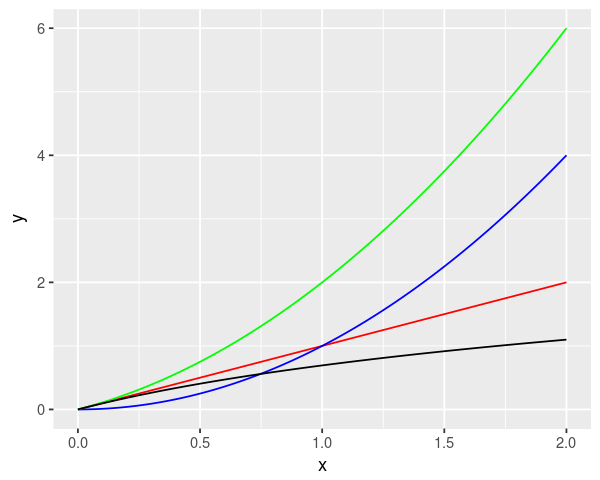

In [82]:
options(repr.plot.width = 5, repr.plot.height = 4)

ggplot(data.frame(x=c(0, 2)), aes(x)) + 
    stat_function(fun = function (x) { x }, colour = "red") +
    stat_function(fun = function (x) { x^2 }, colour = "blue") +
    stat_function(fun = function (x) { x + x^2 }, colour = "green") +
    stat_function(fun = function (x) { log(x + 1) }, colour = "black")

In [54]:
x <- 
    df.training.numeric %>% 
    gather(name, value, -sale_price_log) %>%
    mutate(value.log = log(value + 1), value.sqrt = sqrt(value)) %>%
    group_by(name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(sale_price_log ~ value, .)),
        glance = map(mod, broom::glance),
        r.squared = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(sale_price_log ~ value.log, .)),
        glance.log = map(mod.log, broom::glance),
        r.squared.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sqrt = map(data, ~lm(sale_price_log ~ value.sqrt, .)),
        glance.sqrt = map(mod.sqrt, broom::glance),
        r.squared.sqrt = map_dbl(glance.sqrt, 'r.squared')
    ) %>%
    select(-data)

x %>% 
    select(name, r.squared, r.squared.log, r.squared.sqrt) %>%
    mutate(
        r2 = r.squared * 100,
        log.gain = r.squared.log / r.squared, 
        sqrt.gain = r.squared.sqrt / r.squared,
        max.gain = pmax(log.gain, sqrt.gain),
        r2.new = max.gain * r2
     ) %>%
    select(name, r2, log.gain, sqrt.gain,max.gain, r2.new) %>%
    filter(max.gain > 1.05, r2.new > 10) %>%
    arrange(desc(r2), max.gain)
#      gather(fun, value, -name) %>%
#      arrange(name, desc(value)) %>%
#      group_by(name) %>%
#      filter(row_number() == 1) %>%
#      arrange(desc(value)) %>%
#      filter(value > 1.2) %>%
#      select(`Attribute Name` = name, `Transformation` = fun, `Transformation R.Squared Gain` = value)

name,r2,log.gain,sqrt.gain,max.gain,r2.new
GrLivArea,49.129817,1.0854313,1.063073,1.085431,53.32704
Fireplaces,23.956074,1.0811631,1.099671,1.099671,26.34379
MasVnrArea,18.213701,0.9379289,1.065036,1.065036,19.39825
WoodDeckSF,11.164625,1.0540031,1.124479,1.124479,12.55438
OpenPorchSF,10.307501,2.0524076,1.774221,2.052408,21.15519
HalfBath,9.858485,1.0447120,1.060540,1.060540,10.45532
LotArea,6.621353,2.4154951,2.038663,2.415495,15.99384


In [55]:
x <- 
    df.training.numeric %>% 
    gather(name, value, -sale_price_log) %>%
    mutate(value.log = log(value + 1), value.sqrt = sqrt(value)) %>%
    group_by(name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(sale_price_log ~ value, .)),
        glance = map(mod, broom::glance),
        r.squared = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(sale_price_log ~ value + value.log, .)),
        glance.log = map(mod.log, broom::glance),
        r.squared.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sqrt = map(data, ~lm(sale_price_log ~ value + value.sqrt, .)),
        glance.sqrt = map(mod.sqrt, broom::glance),
        r.squared.sqrt = map_dbl(glance.sqrt, 'r.squared')
    ) %>%
    select(-data)

x %>% 
    select(name, r.squared, r.squared.log, r.squared.sqrt) %>%
    mutate(
        r2 = r.squared * 100,
        log.gain = r.squared.log / r.squared, 
        sqrt.gain = r.squared.sqrt / r.squared,
        max.gain = pmax(log.gain, sqrt.gain),
        r2.new = max.gain * r2
     ) %>%
    select(name, r2, log.gain, sqrt.gain,max.gain, r2.new) %>%
    filter(max.gain > 1.05, r2.new > 10) %>%
    arrange(desc(r2), max.gain)

name,r2,log.gain,sqrt.gain,max.gain,r2.new
GrLivArea,49.129817,1.086142,1.089199,1.089199,53.51212
YearBuilt,34.406465,1.181568,1.181558,1.181568,40.65358
Fireplaces,23.956074,1.105279,1.105926,1.105926,26.49363
MasVnrArea,18.213701,1.077382,1.075763,1.077382,19.62311
BsmtFinSF1,13.840117,1.149954,1.136283,1.149954,15.91550
GarageYrBlt,12.181050,2.914141,2.917814,2.917814,35.54204
WoodDeckSF,11.164625,1.105202,1.125169,1.125169,12.56209
OpenPorchSF,10.307501,2.096347,2.130713,2.130713,21.96232
X2ndFlrSF,10.195248,2.142678,2.118172,2.142678,21.84513
HalfBath,9.858485,1.116047,1.116047,1.116047,11.00253


In [57]:
x <- 
    df.training.numeric %>% 
    gather(name, value, -sale_price_log) %>%
    mutate(value.x2 = value*value, value.x15 = value^(1.5)) %>%
    group_by(name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(sale_price_log ~ value, .)),
        glance = map(mod, broom::glance),
        r.squared = map_dbl(glance, 'r.squared'),
        
        mod.x2 = map(data, ~lm(sale_price_log ~ value + value.x2, .)),
        glance.x2 = map(mod.x2, broom::glance),
        r.squared.x2 = map_dbl(glance.x2, 'r.squared'),
        
        mod.x15 = map(data, ~lm(sale_price_log ~ value + value.x15, .)),
        glance.x15 = map(mod.x15, broom::glance),
        r.squared.x15 = map_dbl(glance.x15, 'r.squared')
    ) %>%
    select(-data, -contains("mod"))

x %>% 
    select(name, r.squared, r.squared.x2, r.squared.x15) %>%
    mutate(
        r2 = r.squared * 100,
        x2.gain = r.squared.x2 / r.squared, 
        x15.gain = r.squared.x15 / r.squared,
        max.gain = pmax(x2.gain, x15.gain),
        r2.new = max.gain * r2
     ) %>%
    select(name, r2, x2.gain, x15.gain, max.gain, r2.new) %>%
    filter(max.gain > 1.05, r2.new > 10) %>%
    arrange(desc(r2), max.gain)

name,r2,x2.gain,x15.gain,max.gain,r2.new
GrLivArea,49.129817,1.091454,1.091912,1.091912,53.64545
TotalBsmtSF,37.470800,1.074199,1.048156,1.074199,40.25108
X1stFlrSF,35.638637,1.066107,1.060283,1.066107,37.99461
YearBuilt,34.406465,1.181509,1.181529,1.181529,40.65223
Fireplaces,23.956074,1.101448,1.104047,1.104047,26.44863
MasVnrArea,18.213701,1.057797,1.063730,1.063730,19.37445
GarageYrBlt,12.181050,2.933359,2.928227,2.933359,35.73140
WoodDeckSF,11.164625,1.130706,1.145405,1.145405,12.78802
OpenPorchSF,10.307501,1.731154,1.911578,1.911578,19.70359
X2ndFlrSF,10.195248,1.850655,1.951890,1.951890,19.90000
